# Yellow Taxi Demand Prediction in New York City

## Libraries

In [0]:
#!pip install graphviz
#!pip install cloudpickle
#!pip install dask
#!pip install folium
#!pip install gpxpy
#!apt-get install graphviz

In [0]:
# For dataframes
import dask.dataframe as dd
import pandas as pd

# Open Street Map
import folium

# UNIX time conversion
import datetime
import time

# Arithmetic operations on array
import numpy as np

# Plotting
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams

# For calculating distance between two points in miles
import gpxpy.geo

# For clustering
from sklearn.cluster import MiniBatchKMeans, KMeans

import math
import pickle
import os

# ML models
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# Performance Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

## Data Information

Data Source - NYC Taxi and Limousine Commission (TLC) - https://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml


### Information on Taxies
#### Yellow Taxi: Yellow Medallion Taxicabs
These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.
#### For Hire Vehicles (FHVs)
FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged.
#### Green Taxi: Street Hail Livery (SHL)
The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides.

Credits: [Quora](https://www.quora.com/What-is-the-difference-between-Green-Cabs-and-Yellow-Cabs)

## Data Collection

Yellow Taxi trip data of 2016

In [0]:
import requests
url = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-01.csv"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
  r = requests.get(url)
  f.write(r.content)

In [6]:
month = dd.read_csv('yellow_tripdata_2016-01.csv')
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RatecodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


## Features in Dataset
**Source** - http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf
<table border="1">
    <tr>
        <th>Field Name</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>VendorID</td>
        <td>
        A code indicating the TPEP provider that provided the record.
        <ol>
          <li>Creative Mobile Technologies</li>
          <li>VeriFone Inc.</li>
        </ol>
        </td>
    </tr>
    <tr>
        <td>tpep_pickup_datetime</td>
        <td>The date and time when the meter was engaged.</td>
    </tr>
    <tr>
        <td>tpep_dropoff_datetime</td>
        <td>The date and time when the meter was disengaged.</td>
    </tr>
    <tr>
        <td>Passenger_count</td>
        <td>The number of passengers in the vehicle. This is a driver-entered value.</td>
    </tr>
    <tr>
        <td>Trip_distance</td>
        <td>The elapsed trip distance in miles reported by the taximeter.</td>
    </tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>Longitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
    <tr>
        <td>Store_and_fwd_flag</td>
        <td>
            This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br> 
            aka “store and forward,” because the vehicle did not have a connection to the server.<br>
            Y= store and forward trip<br>
            N= not a store and forward trip
        </td>
    </tr>
	<tr>
		<td>Dropoff_longitude</td>
		<td>Longitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Dropoff_ latitude</td>
		<td>Latitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Payment_type</td>
		<td>A numeric code signifying how the passenger paid for the trip.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute</li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
	<tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.</td>
	</tr>
	<tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
	<tr>
		<td>Improvement_surcharge</td>
		<td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.</td>
	</tr>
	<tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
	<tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
	<tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
</table>

## ML Problem Formulation
**Time Series Forcasting and Regression**
- To find number of pickups, given location cordinates(latitude and longitude) and time, in the query reigion and surrounding regions.
- To solve the above I am using data collected in Jan - Mar 2016 to predict the pickups in Jan - Mar 2017.

### Performance Metrics
1. Mean Absolute Percentage Error.
2. Mean Squared Error.

## Data Cleaning

Data Preview

In [7]:
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8


### 1. Pickup Latitude & Pickup Longitude

New York is bounded by the location cordinates ( lat, long ) - (40.5774, -74.15) & (40.9176, -73.7004) so hence any cordinates not within these cordinates are not considered by us as we are only concerned with pickups which originate within New York.</br>
Source for bounding coordinates - https://www.flickr.com/places/info/2459115

In [8]:
outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774)| \
                   (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

# Displaying few points outside New York City
sample_locations = outlier_locations.head(1000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(map_osm)
map_osm

### 2. Dropoff Latitude & Dropoff Longitude

In [9]:
outlier_locations = month[((month.dropoff_longitude <= -74.15) | (month.dropoff_latitude <= 40.5774)| \
                   (month.dropoff_longitude >= -73.7004) | (month.dropoff_latitude >= 40.9176))]

map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')

sample_locations = outlier_locations.head(1000)
for i,j in sample_locations.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(map_osm)
map_osm

### 3. Trip Duration

According to NYC Taxi & Limousine Commision Regulations the maximum **allowed trip duration in a 24 hour interval is 12 hours.**

In [0]:
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())
  
def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    #pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    #append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame
  
frame_with_durations = return_with_trip_times(month)

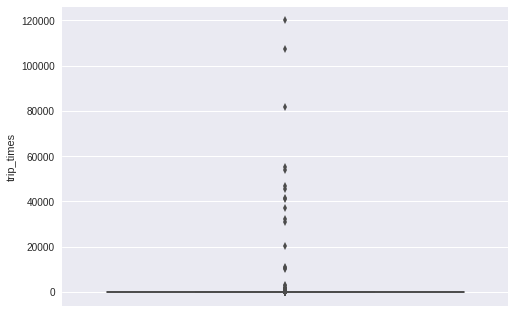

In [11]:
sns.boxplot(y="trip_times", data =frame_with_durations)
plt.show()

In [12]:
for i in range(0,100,10):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is -43.95
10 percentile value is 3.933333333333333
20 percentile value is 5.566666666666666
30 percentile value is 7.1
40 percentile value is 8.683333333333334
50 percentile value is 10.466666666666667
60 percentile value is 12.55
70 percentile value is 15.2
80 percentile value is 18.933333333333334
90 percentile value is 25.516666666666666
100 percentile value is  119912.7


In [13]:
for i in range(90,100):
    var =frame_with_durations["trip_times"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 25.516666666666666
91 percentile value is 26.55
92 percentile value is 27.733333333333334
93 percentile value is 29.116666666666667
94 percentile value is 30.733333333333334
95 percentile value is 32.7
96 percentile value is 35.233333333333334
97 percentile value is 38.666666666666664
98 percentile value is 43.916666666666664
99 percentile value is 53.9
100 percentile value is  119912.7


In [0]:
# removing outlier
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<720)]

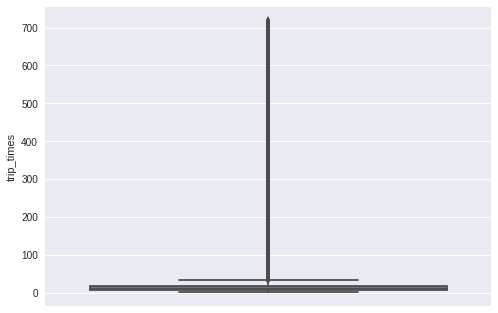

In [15]:
# plotting boxplot after removing data
sns.boxplot(y="trip_times", data =frame_with_durations_modified)
plt.show()

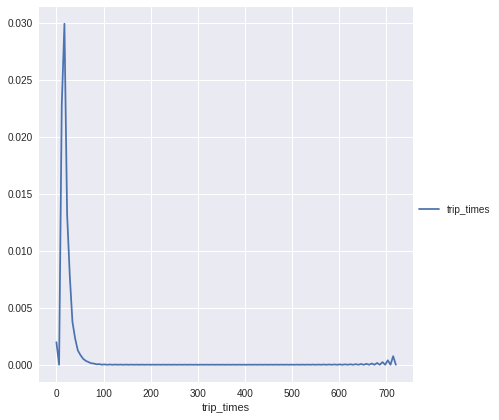

In [16]:
#pdf of trip-times after removing the outliers
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend();
plt.show();

In [0]:
#converting the values to log-values to check for log-normal
import math
frame_with_durations_modified['log_times']=[math.log(i) for i in frame_with_durations_modified['trip_times'].values]

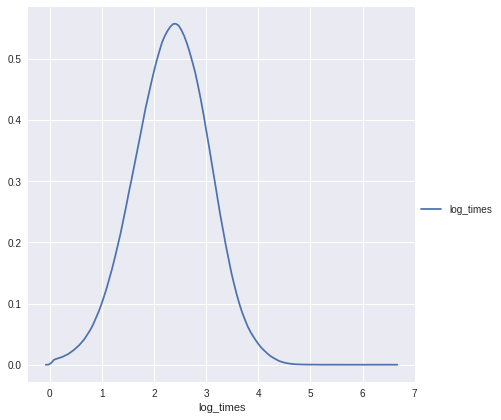

In [18]:
#pdf of log-values
sns.FacetGrid(frame_with_durations_modified,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

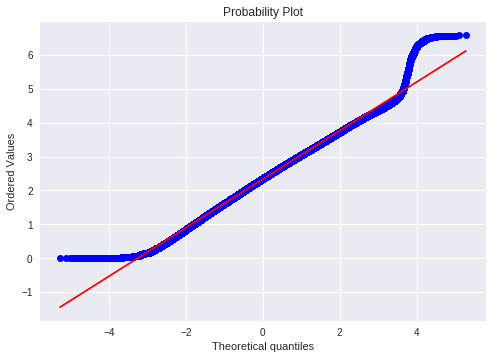

In [19]:
#Q-Q plot for checking if trip-times is log-normal
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()

**Observation** : Q-Q plot showes that distrubution log-normal from std-dev -3 to 3

### 4. Speed

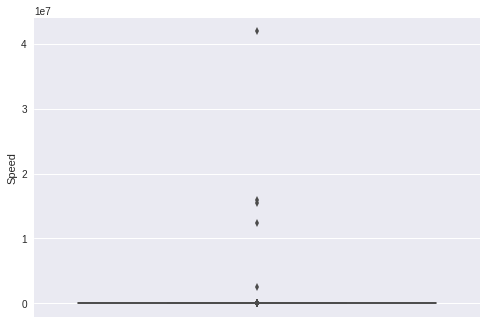

In [20]:
frame_with_durations_modified['Speed'] = 60*(frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="Speed", data =frame_with_durations_modified)
plt.show()

In [21]:
for i in range(0,100,10):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.011787819253438
20 percentile value is 7.390029325513196
30 percentile value is 8.49689440993789
40 percentile value is 9.545454545454543
50 percentile value is 10.638522427440636
60 percentile value is 11.87948350071736
70 percentile value is 13.432835820895523
80 percentile value is 15.6734693877551
90 percentile value is 20.035906642728904
100 percentile value is  41917233.8028169


In [22]:
for i in range(90,100):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.035906642728904
91 percentile value is 20.77922077922078
92 percentile value is 21.62544169611307
93 percentile value is 22.594142259414227
94 percentile value is 23.720930232558143
95 percentile value is 25.043478260869566
96 percentile value is 26.641366223908914
97 percentile value is 28.652097902097903
98 percentile value is 31.304347826086957
99 percentile value is 35.33428165007113
100 percentile value is  41917233.8028169


In [23]:
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["Speed"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.33428165007113
99.1 percentile value is 35.89123867069487
99.2 percentile value is 36.49769585253456
99.3 percentile value is 37.17507418397626
99.4 percentile value is 37.91878172588833
99.5 percentile value is 38.762376237623755
99.6 percentile value is 39.768642447418735
99.7 percentile value is 41.019230769230774
99.8 percentile value is 42.63212435233161
99.9 percentile value is 45.163636363636364
100 percentile value is  41917233.8028169


Removing further outliers based on the 99.9th percentile value

In [0]:
frame_with_durations_modified=frame_with_durations[(frame_with_durations.Speed>0) & (frame_with_durations.Speed<45.31)]

Average speed of cabs in New-York

In [25]:
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

12.07876826004524

### 5. Trip Distance

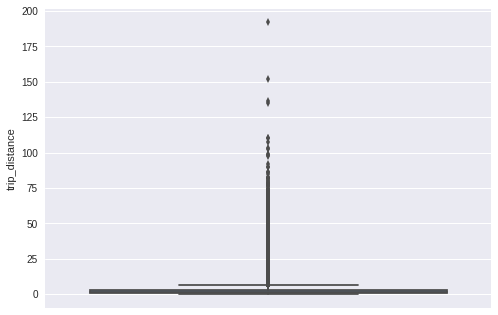

In [26]:
sns.boxplot(y="trip_distance", data =frame_with_durations_modified)
plt.show()

In [27]:
for i in range(0,100,10):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.38
50 percentile value is 1.69
60 percentile value is 2.08
70 percentile value is 2.65
80 percentile value is 3.7
90 percentile value is 6.5
100 percentile value is  191.9


In [28]:
for i in range(90,100):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 6.5
91 percentile value is 7.1
92 percentile value is 7.89
93 percentile value is 8.7
94 percentile value is 9.48
95 percentile value is 10.3
96 percentile value is 11.4
97 percentile value is 13.5
98 percentile value is 16.98
99 percentile value is 18.6
100 percentile value is  191.9


In [29]:
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.6
99.1 percentile value is 18.8
99.2 percentile value is 19.02
99.3 percentile value is 19.3
99.4 percentile value is 19.61
99.5 percentile value is 20.01
99.6 percentile value is 20.5
99.7 percentile value is 21.01
99.8 percentile value is 21.79
99.9 percentile value is 23.9
100 percentile value is  191.9


Removing further outliers based on the 99.9th percentile value

In [0]:
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance>0) & (frame_with_durations.trip_distance<23)]

Box-plot after removal of outliers

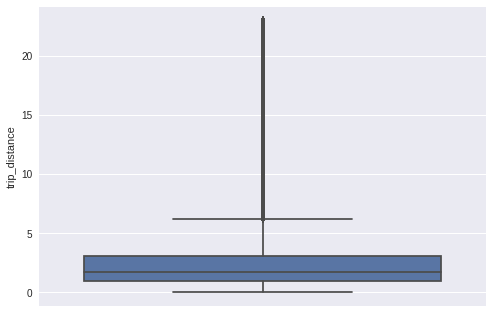

In [31]:
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

### 6. Total Fare

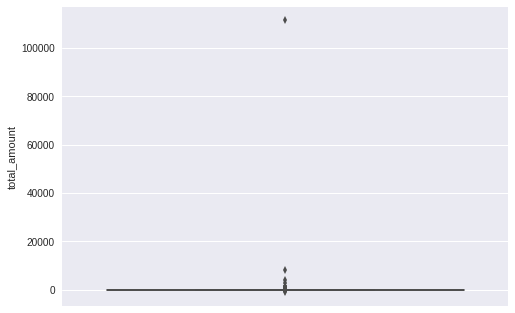

In [32]:
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [33]:
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -958.4
10 percentile value is 6.8
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 10.3
50 percentile value is 11.62
60 percentile value is 13.3
70 percentile value is 15.36
80 percentile value is 19.24
90 percentile value is 27.96
100 percentile value is  111271.65


In [34]:
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 27.96
91 percentile value is 29.84
92 percentile value is 32.3
93 percentile value is 35.34
94 percentile value is 38.8
95 percentile value is 42.34
96 percentile value is 46.61
97 percentile value is 52.8
98 percentile value is 58.55
99 percentile value is 69.99
100 percentile value is  111271.65


In [35]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 69.99
99.1 percentile value is 69.99
99.2 percentile value is 70.01
99.3 percentile value is 70.01
99.4 percentile value is 70.01
99.5 percentile value is 70.01
99.6 percentile value is 72.89
99.7 percentile value is 72.92
99.8 percentile value is 78.34
99.9 percentile value is 92.76
100 percentile value is  111271.65


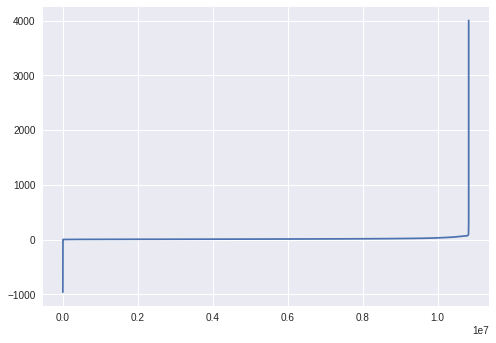

In [36]:
plt.plot(var[:-2])
plt.show()

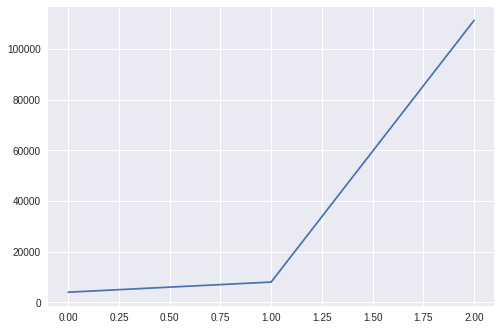

In [37]:
plt.plot(var[-3:])
plt.show()

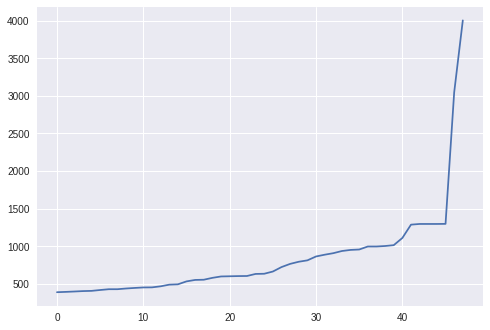

In [38]:
plt.plot(var[-50:-2])
plt.show()

## Remove all outliers points.

In [0]:
def remove_outliers(new_frame):

    
    a = new_frame.shape[0]
    print ("Number of pickup records = ",a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print ("Number of outlier coordinates lying outside NY boundaries:",(a-b))

    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_frame.shape[0])
    print ("---")
    return new_frame

In [40]:
print ("Removing outliers in the month of Jan-2015")
print ("----")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("fraction of data points that remain after removing outliers", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

Removing outliers in the month of Jan-2015
----
Number of pickup records =  10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 21047
Number of outliers from fare analysis: 4991
Total outliers removed 297784
---
fraction of data points that remain after removing outliers 0.9726975449758308


## Data Preperation

### Clustering / Segmentation

In [41]:
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print("On choosing a cluster size of ",cluster_len)
    print("Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)))
    print("Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)))
    print("Min inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)  

On choosing a cluster size of  10
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0
Min inter-cluster distance =  0.9866648594954689 
---
On choosing a cluster size of  20
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 5.0
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 15.0
Min inter-cluster distance =  0.6152041657282724 
---
On choosing a cluster size of  30
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 7.0
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 23.0
Min inter-cluster distance =  0.5463175334037291 
---
On choosing a cluster size of  40
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 9.0
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 31.0
Min inter-cluster distance =  0.4419707

In [0]:
kmeans = MiniBatchKMeans(n_clusters=30, batch_size=10000,random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

### Plotting the cluster centers:

In [43]:
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

### Plotting the clusters:

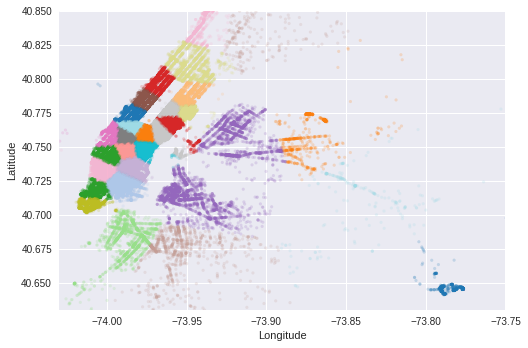

In [44]:
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, lw=0,
               c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)